In [1]:

import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
#Select for hvgs
adata = sc.read_loom('/home/tchari/counts/monod_liver/loom/liver_c72_sn.loom')


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
adata

AnnData object with n_obs × n_vars = 9054 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [8]:
meta = pd.read_csv('/home/tchari/metadata/liver_GSE185477_Final_Metadata.txt',sep='\t')
meta.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C41_AAACCTGAGCCTTGAT,C41,428,199,32.087912,AAACCTGAGCCTTGAT,C41,C41_AAACCTGAGCCTTGAT,-0.009246,-0.016106,G1,C41,single_cell,11,InterHep,Hepatocyte,Hep_6,Hep_Unidentified,-3.321926,-6.397605
C41_AAACCTGAGGTCATCT,C41,275,181,19.666667,AAACCTGAGGTCATCT,C41,C41_AAACCTGAGGTCATCT,-0.018254,-0.027253,G1,C41,single_cell,10,cvLSECs,LSECs,LSEC_1,LSEC_Central Venous LSEC,14.034962,2.834506
C41_AAACCTGAGTCGCCGT,C41,632,264,15.703704,AAACCTGAGTCGCCGT,C41,C41_AAACCTGAGTCGCCGT,-0.010180,-0.027701,G1,C41,single_cell,13,Bcells,Bcells,Lymph_5,Lymph_Mature B cells,-1.928654,-7.027950
C41_AAACCTGAGTGGAGTC,C41,10508,1923,12.188988,AAACCTGAGTGGAGTC,C41,C41_AAACCTGAGTGGAGTC,0.030654,-0.030400,S,C41,single_cell,4,InterHep,Hepatocyte,Hep_4,Hep_PP2,1.582531,3.822350
C41_AAACCTGAGTTAACGA,C41,503,220,26.355140,AAACCTGAGTTAACGA,C41,C41_AAACCTGAGTTAACGA,-0.020764,-0.021055,G1,C41,single_cell,7,NKTcell,NKTcell,Lymph_0,Lymph_ab T cells,-2.318836,-13.029733


In [139]:
donor = 'C72_TST'
meta_sub = meta[meta['sample']==donor]
print(np.unique(meta_sub['assay_type']))
meta_sub.head()

['single_nuc']


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C72_TST_AAACCCAAGCAACTCT,C72_TST,11063,3465,0.920691,AAACCCAAGCAACTCT,C72,C72_TST_AAACCCAAGCAACTCT,-0.006325,-0.022941,G1,C72_TST,single_nuc,0,PortalHep,Hepatocyte,Hep_2,Hep_PP1,-1.199285,4.710606
C72_TST_AAACCCAAGTGGACGT,C72_TST,4438,2103,1.797980,AAACCCAAGTGGACGT,C72,C72_TST_AAACCCAAGTGGACGT,-0.039295,-0.037965,G1,C72_TST,single_nuc,2,PortalHep,Hepatocyte,Hep_5,Hep_PP1,-2.899850,1.370558
C72_TST_AAACCCACACCTTCGT,C72_TST,13362,3581,0.845337,AAACCCACACCTTCGT,C72,C72_TST_AAACCCACACCTTCGT,-0.002458,-0.007107,G1,C72_TST,single_nuc,6,CentralHep,Hepatocyte,Hep_0,Hep_CV1,-3.660515,6.861408
C72_TST_AAACCCACAGGATGAC,C72_TST,19475,4716,1.752759,AAACCCACAGGATGAC,C72,C72_TST_AAACCCACAGGATGAC,-0.029511,0.016113,G2M,C72_TST,single_nuc,8,CentralHep,Hepatocyte,Hep_3,Hep_PP1,-0.076799,6.225614
C72_TST_AAACCCAGTCCACAGC,C72_TST,17222,4194,10.242674,AAACCCAGTCCACAGC,C72,C72_TST_AAACCCAGTCCACAGC,-0.033497,-0.002020,G1,C72_TST,single_nuc,4,InterHep,Hepatocyte,Hep_8,Hep_PP2,1.933817,2.004221


In [140]:
meta_sub['sub_annotation'].value_counts() #Filter out doublets

Hep_PP1                          3382
Hep_CV1                          1811
Hep_IZ1                          1051
Hep_PP2                           992
Doublet/Contamination             599
LSEC_Central Venous LSEC          313
Hep_IZ2                           303
Stellate_HSC1                     118
Hep_Unidentified                   99
Chol_bipotent progenitors          81
LSEC_Periportal LSEC               67
LSEC_Portal Endothelial            48
Stellate_HSC2                      38
Chol_BCL2+ Cholangiocytes          24
Chol_Cholangiocytes                22
Chol_CV hepatocytes                22
Lymph_ab T cells                   20
Chol_hepatocyte progenitors 1      18
Chol_hepatocyte progenitors 2      12
Stellate_HSC6                       6
Lymph_gd T cells                    6
Lymph_NK cells                      6
Stellate_HSC4                       3
Lymph_Plasma B cells                2
Stellate_HSC7                       2
Lymph_Mature B cells                2
Stellate_HSC

**Make final metadata and count/loom file for subsetted cells**

In [111]:
tokeep = list(meta_sub['Subcluster_Group'].value_counts().index[meta_sub['Subcluster_Group'].value_counts() > 100])
tokeep

['Hepatocyte', 'LSECs', 'Stellate', 'Macrophage', 'Cholangiocyte', 'Bcells']

In [112]:
tokeep = ['LSECs', 'Stellate', 'Macrophage', 'Cholangiocyte', 'Bcells']

In [113]:
meta_sub = meta_sub[meta_sub['Subcluster_Group'].isin(tokeep)]
meta_sub.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C72_TST_AAACGAATCAATCGGT,C72_TST,6598,2753,1.536611,AAACGAATCAATCGGT,C72,C72_TST_AAACGAATCAATCGGT,0.000864,0.013842,G2M,C72_TST,single_nuc,9,cvLSECs,LSECs,LSEC_0,LSEC_Central Venous LSEC,13.438443,1.340094
C72_TST_AAACGCTGTTCCTACC,C72_TST,5348,2440,1.146560,AAACGCTGTTCCTACC,C72,C72_TST_AAACGCTGTTCCTACC,-0.042525,0.032498,G2M,C72_TST,single_nuc,9,cvLSECs,LSECs,LSEC_0,LSEC_Central Venous LSEC,11.682501,1.483298
C72_TST_AAAGGATGTTAGCTAC,C72_TST,1974,1175,5.806452,AAAGGATGTTAGCTAC,C72,C72_TST_AAAGGATGTTAGCTAC,-0.074785,-0.064320,G1,C72_TST,single_nuc,12,Stellate,Stellate,Excluded,Doublet/Contamination,6.667694,-2.311169
C72_TST_AAAGGTAAGAATTCAG,C72_TST,3580,1917,4.572158,AAAGGTAAGAATTCAG,C72,C72_TST_AAAGGTAAGAATTCAG,-0.002064,-0.031529,G1,C72_TST,single_nuc,17,NonInfMac,Macrophage,Excluded,Doublet/Contamination,4.161178,-11.607573
C72_TST_AAAGGTAGTCGCCTAG,C72_TST,3858,2046,1.473636,AAAGGTAGTCGCCTAG,C72,C72_TST_AAAGGTAGTCGCCTAG,-0.034700,-0.059637,G1,C72_TST,single_nuc,10,cvLSECs,LSECs,LSEC_1,LSEC_Central Venous LSEC,11.878304,2.271782


In [114]:
bars = list(meta_sub.cell_barcode)
adata_sub = adata[adata.obs['barcode'].isin(bars)]
adata_sub

View of AnnData object with n_obs × n_vars = 1364 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [115]:
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)
sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to highly variable genes
adata_hvg = adata_sub[:, adata_sub.var.highly_variable]

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [116]:
adata_hvg

View of AnnData object with n_obs × n_vars = 1364 × 2000
    obs: 'barcode'
    var: 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'matrix', 'spliced', 'unspliced'

In [117]:
#adata_hvg = adata_sub
adata_hvg.layers['spliced'].shape

(1364, 2000)

In [118]:
#Save adata_hvg to loom
allS = adata_hvg.layers['spliced']
allU = adata_hvg.layers['unspliced']
retAdata = anndata.AnnData(
			X=allS,
			layers={
				'spliced': allS,
				'unspliced': allU
			},
			obs=pd.DataFrame({'barcode': np.array(adata_hvg.obs['barcode'])},index=np.array(adata_hvg.obs['barcode'])),
			var=pd.DataFrame({'gene_name': np.array(adata_hvg.var['gene_name'])},index=np.array(adata_hvg.var['gene_name']))
		)

retAdata.write_loom('/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom')

In [119]:
ds = lp.connect('/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom')


In [120]:
ds.layers['spliced'][:,:].shape

(2000, 1364)

In [121]:
ds.close()

## **Initialize Data for Inference**

In [122]:
chosen = [tokeep,tokeep] #[['L5_IT','L2-3_IT','L6_IT'],['L6_CT','L2-3_IT','L6_IT']] 
individs = []
for names in chosen:
    individs += [[i] for i in names]

In [123]:
num_ks = 3
ks = [3,5,7,3,5,7]

In [124]:
dataset_meta = ['hvg_liver_c72_sn']
print('dataset_meta: ', dataset_meta)
print()



#DUSP9_MAPK1__DUSP9_MAPK1 may have 'multiple transcriptional states'
subcluster_names = []
for r in range(len(chosen)):
    subcluster_names += [chosen[r]]*num_ks

subcluster_names += individs

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(len(ks)):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i])
    
cluster_names = []
dataset_names = [dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/monod_liver/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['hvg_liver_c72_sn']

dataset_names:  ['hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3', 'hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5', 'hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k7', 'hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3', 'hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5', 'hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k7', 'hvg_liver_c72_sn_LSECs', 'hvg_liver_c72_sn_Stellate', 'hvg_liver_c72_sn_Macrophage', 'hvg_liver_c72_sn_Cholangiocyte', 'hvg_liver_c72_sn_Bcells', 'hvg_liver_c72_sn_LSECs', 'hvg_liver_c72_sn_Stellate', 'hvg_liver_c72_sn_Macrophage', 'hvg_liver_c72_sn_Cholangiocyte', 'hvg_liver_c72_sn_Bcells']
len(dataset_names):  16

loom_filepaths:  ['/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom', '/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom', '/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom', '/h

Dataset hvg_liver_c72_sn. 
	1364 barcodes in loom, 1360 pass filter. AAACGAATCAATCGGTAAACGCTGTTCCTACCAAAGGATGTTAGCTACAAAGGTAAGAATTCAGAAAGGTAGTCGCCTAGAAAGTCCAGACTGAGCAAAGTCCTCACGGGCTAAAGTGAAGCCGCACTAAAGTGATCATCGACAAAAGTGATCTTGTGCCAAATGGAAGTAGTCAAAAATGGACAAGTGCTTAAATGGACAGAGTTGGAAATGGAGTCGTCGGTAACACACCAACGTATCAACACACGTGGTCTGCAACAGGGAGCAAGCCAAACAGGGAGGTTATAGAACCATGAGATTGCGGAACCATGAGGTGCTAGAACCATGGTGTTGAGGAACCATGTCCAGTTCCAACCCAAAGAAATTCGAACCCAAAGATCGCCCAACCCAACACACCAGCAACCCAACATCCCGTTAACCCAATCCCGGTAGAACCTGACAGATTTCGAACCTGACAGCAGAACAACCTTTAGGTTACAAAACGAAAGTCCTTAAGAACGTCACAACTGGTTAACTTCTAGACTCATCAACTTCTAGAGGTCGTAAGACTCCAACGTATCAAGCCATTCCTCTGCAAAGCGTTAGACGACGTAAGCGTTAGATAGGGAAAGCGTTAGTTTGGCTAAGGTAAAGACTCTACAAGTACCCACGTCGTGAAGTCGTAGCATGGGTAAGTCGTCACCCTCTAAAGTCGTCACGGGTAAAAGTCGTCAGGTTCATAAGTGAAAGTACCATCAAGTGAACATGGCACCAAGTTCGCAGGGACTAAATAGAGAGGATAATCAATAGAGGTACACGTTAATAGAGGTTAGGGACAATAGAGTCTCTTCAAAATCACGGTGGATCAGAATCACGTCACGGAGAAATCGACAGTCATACCAATCGACCAAGGCCTCAATCGACCAGACCATTAATGAAGTCAAGAGGCAAT

	['LSECs', 'Stellate', 'Macrophage', 'Cholangiocyte', 'Bcells']: 1364 cells in annotations. 1364 in loom. 1360 pass filter.
	['LSECs', 'Stellate', 'Macrophage', 'Cholangiocyte', 'Bcells']: 1364 cells in annotations. 1364 in loom. 1360 pass filter.
	['LSECs', 'Stellate', 'Macrophage', 'Cholangiocyte', 'Bcells']: 1364 cells in annotations. 1364 in loom. 1360 pass filter.
	['LSECs', 'Stellate', 'Macrophage', 'Cholangiocyte', 'Bcells']: 1364 cells in annotations. 1364 in loom. 1360 pass filter.
	['LSECs']: 505 cells in annotations. 505 in loom. 505 pass filter.
	['Stellate']: 331 cells in annotations. 331 in loom. 331 pass filter.
	['Macrophage']: 238 cells in annotations. 238 in loom. 238 pass filter.
	['Cholangiocyte']: 183 cells in annotations. 183 in loom. 182 pass filter.
	['Bcells']: 107 cells in annotations. 107 in loom. 104 pass filter.
	['LSECs']: 505 cells in annotations. 505 in loom. 505 pass filter.
	['Stellate']: 331 cells in annotations. 331 in loom. 331 pass filter.
	['Macro

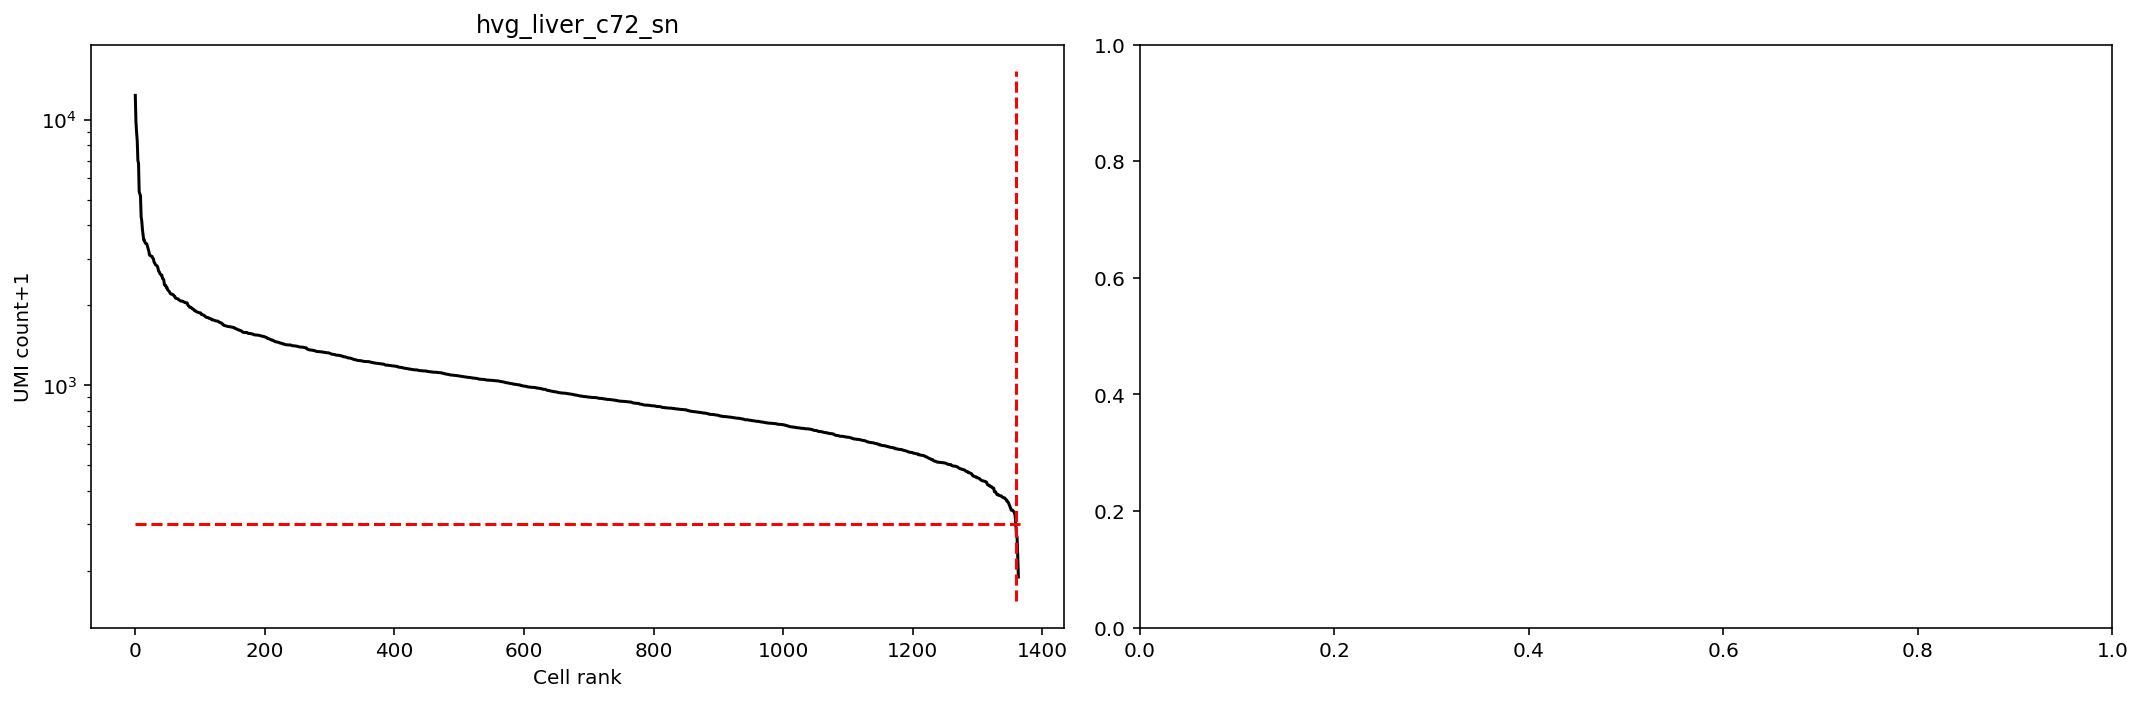

In [127]:
cf = []

#thr_ub = [5e4]*len(dataset_meta)*2
thr_lb = [300]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) #& ((S+U).sum(0)<thr_ub[k])
        
        n_annot_bcs = meta_sub['cell_barcode'].sum()
        annot_bcs_in_loom = meta_sub['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta_sub['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta_sub[(meta_sub['Subcluster_Group'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_top_liver_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [130]:
all_assigns = [list(meta_sub['Subcluster_Group'][meta_sub['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

1360


In [131]:
all_assigns2 = [list(meta_sub['Subcluster_Group'][meta_sub['cell_barcode'] == i])[0] for i in bcs[cf[3]]]
print(len(all_assigns2))

1360


In [132]:
assigns = [all_assigns]*num_ks + [all_assigns2]*num_ks

## **Gene Filtering**

In [133]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230419_025_liver_MM_1 already exists.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3
INFO:root:1360 cells detected.
INFO:root:2000 features observed, 1987 match genome annotations. 1975 were unique.
INFO:root:378 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230419_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3 created.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5
INFO:root:1360 cells detected.
INFO:root:2000 features observed, 1987 match genome annotations. 1975 were unique.
INFO:root:378 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230419_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5 created.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k7
INFO:root:1360 cells detecte

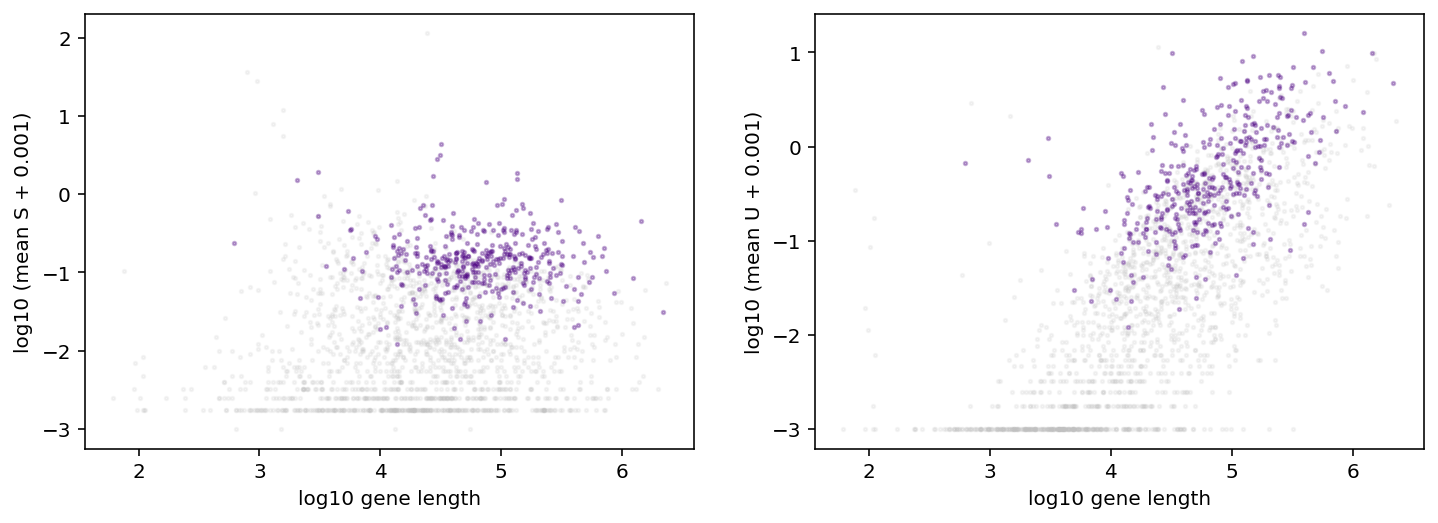

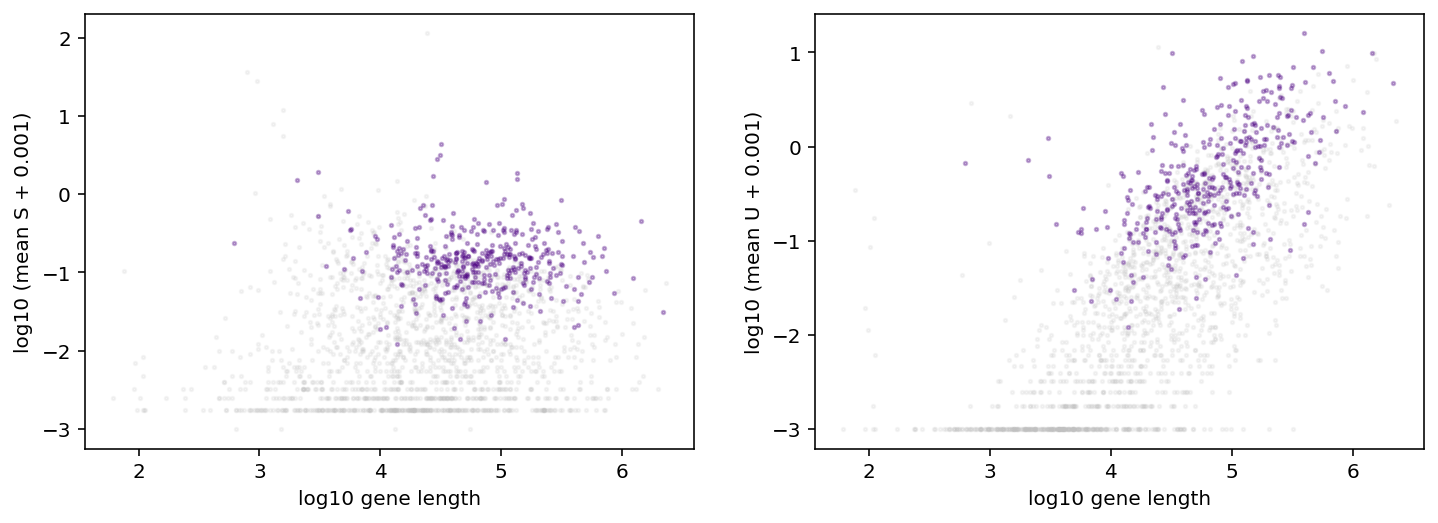

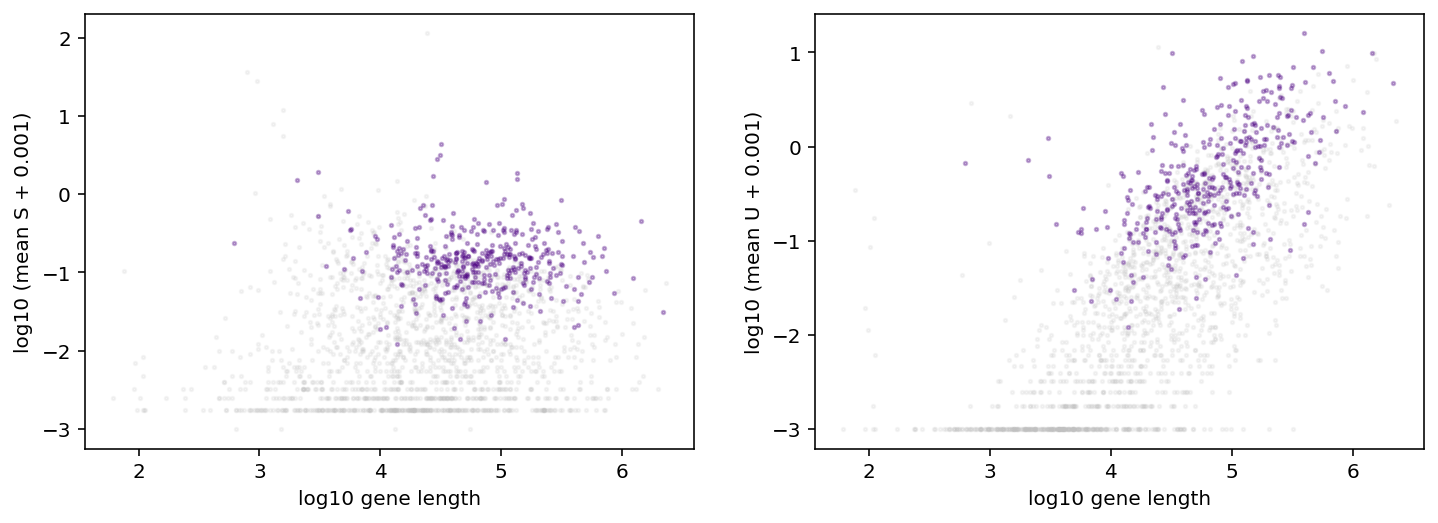

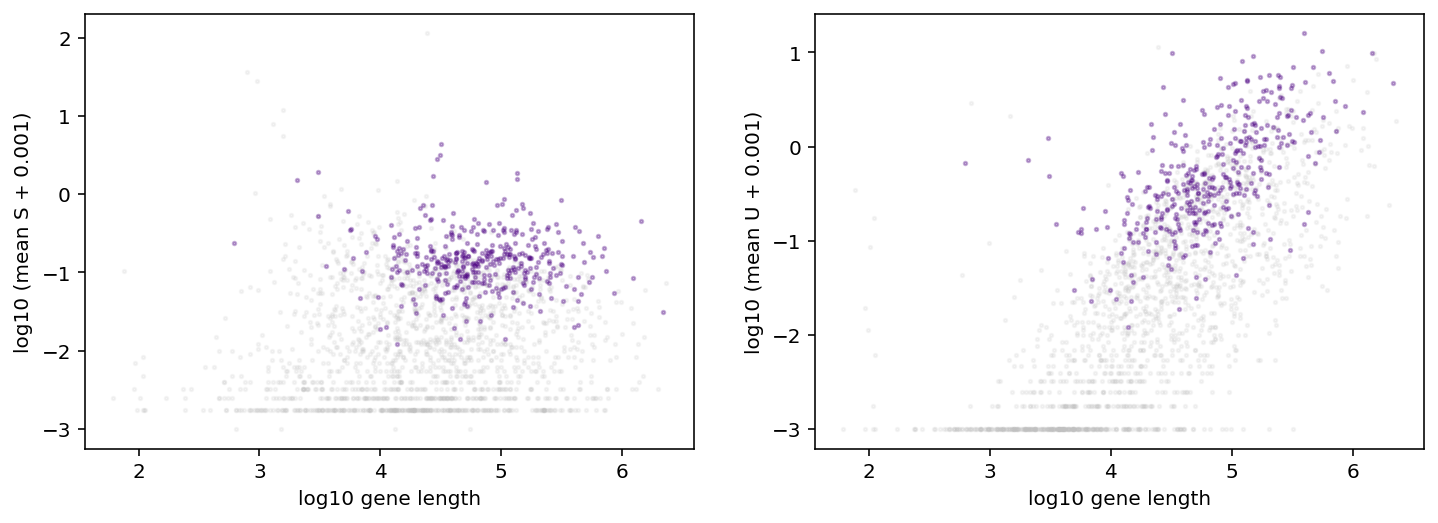

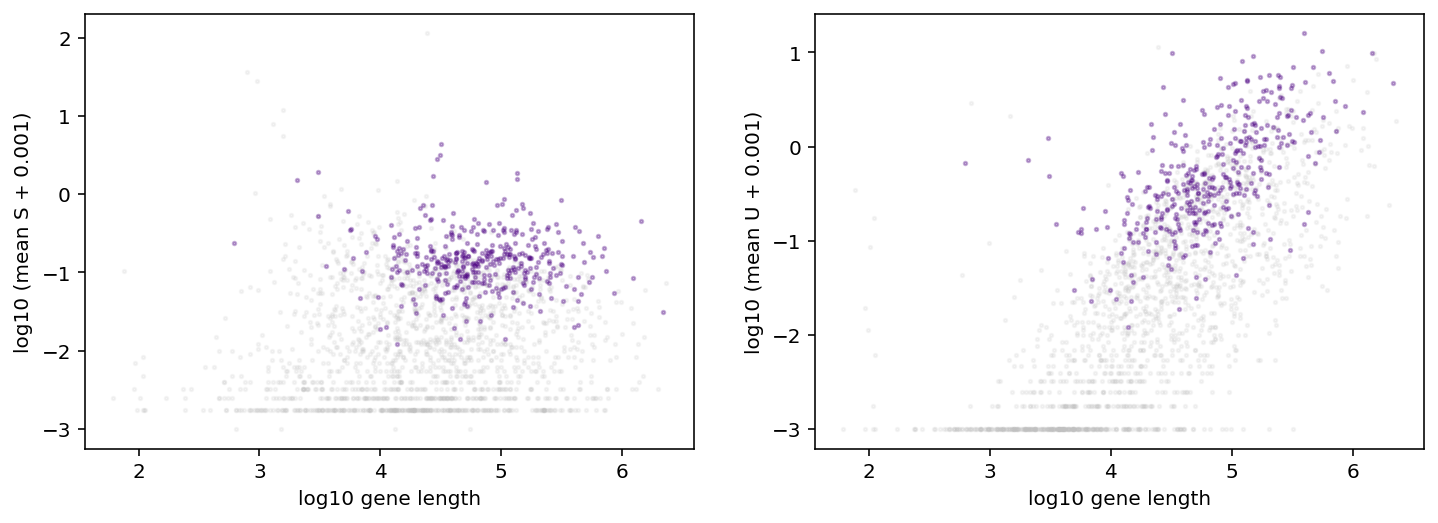

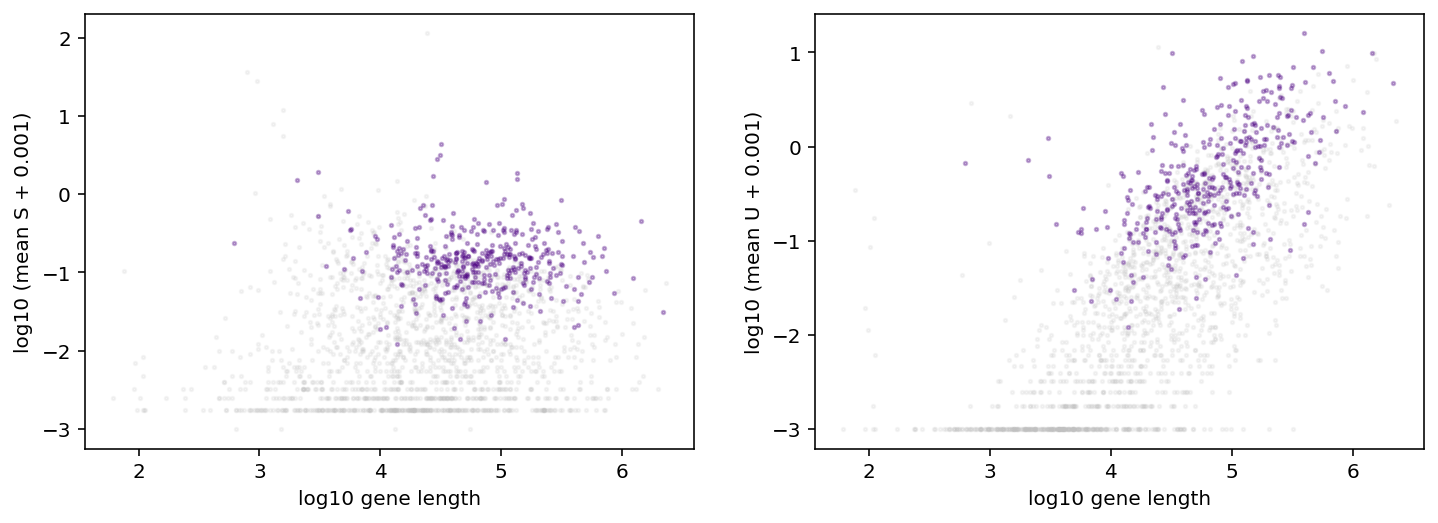

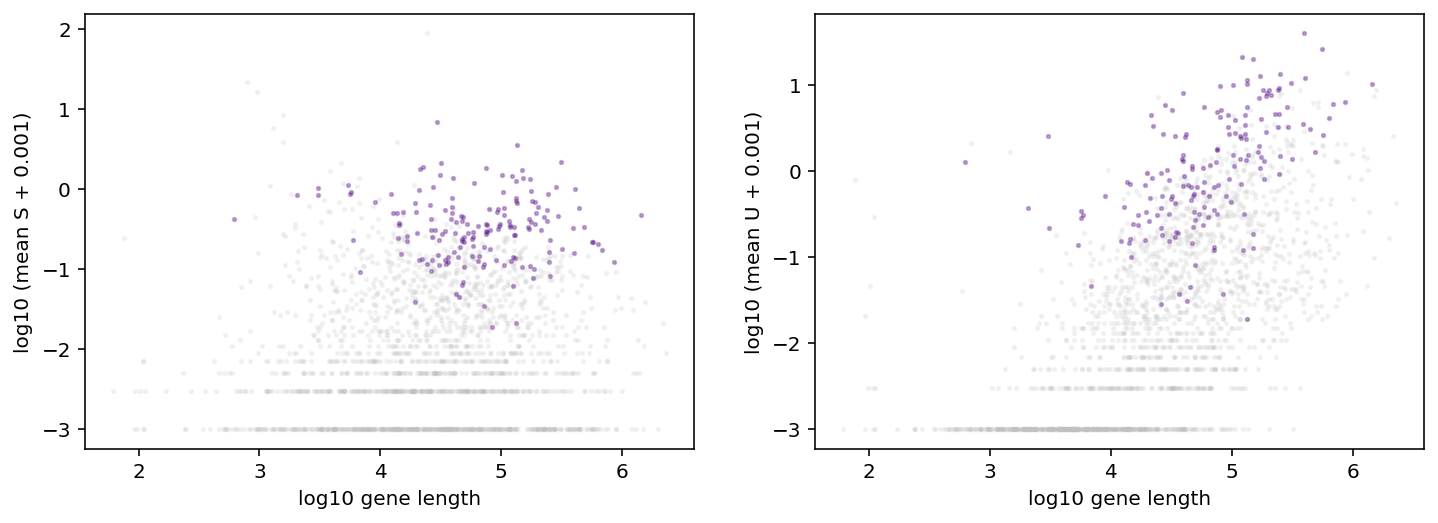

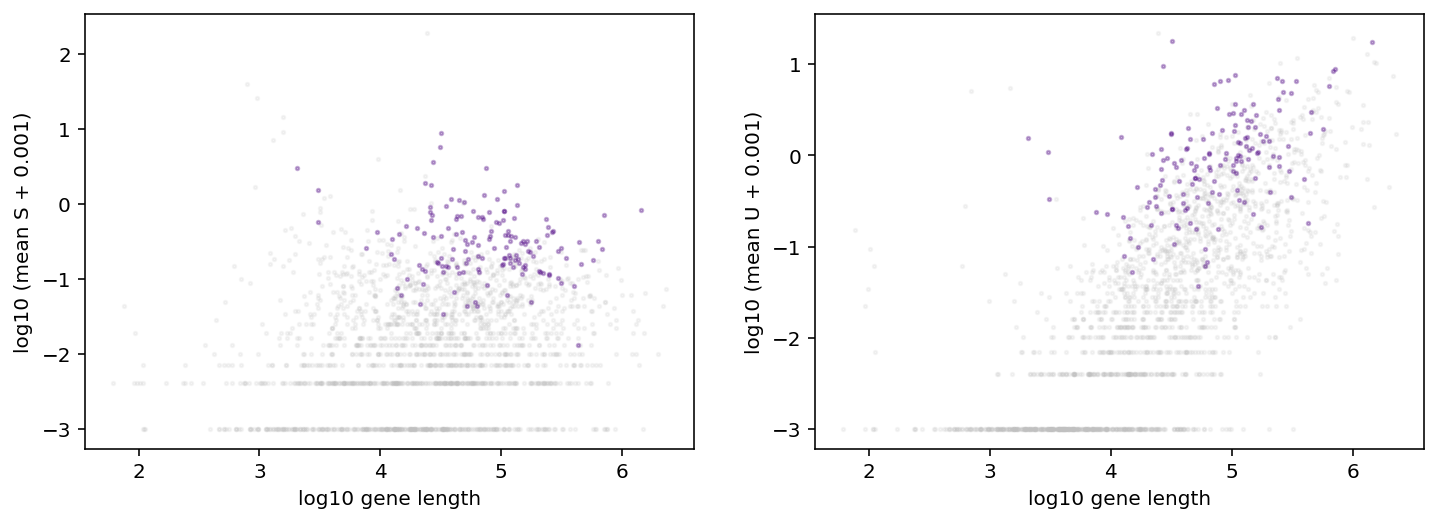

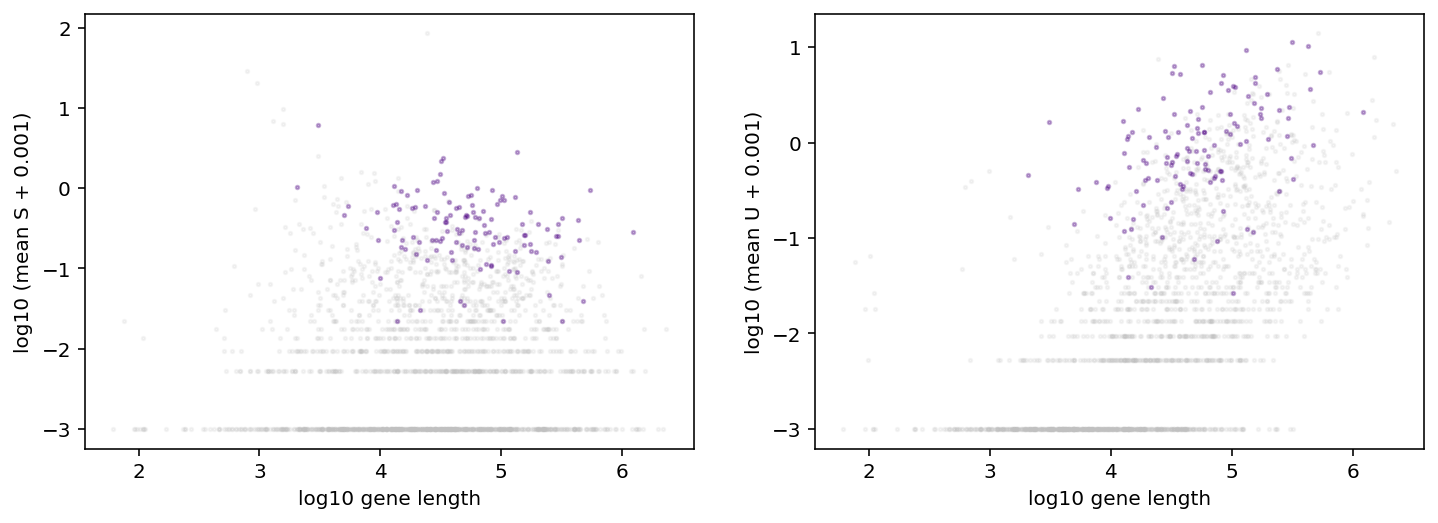

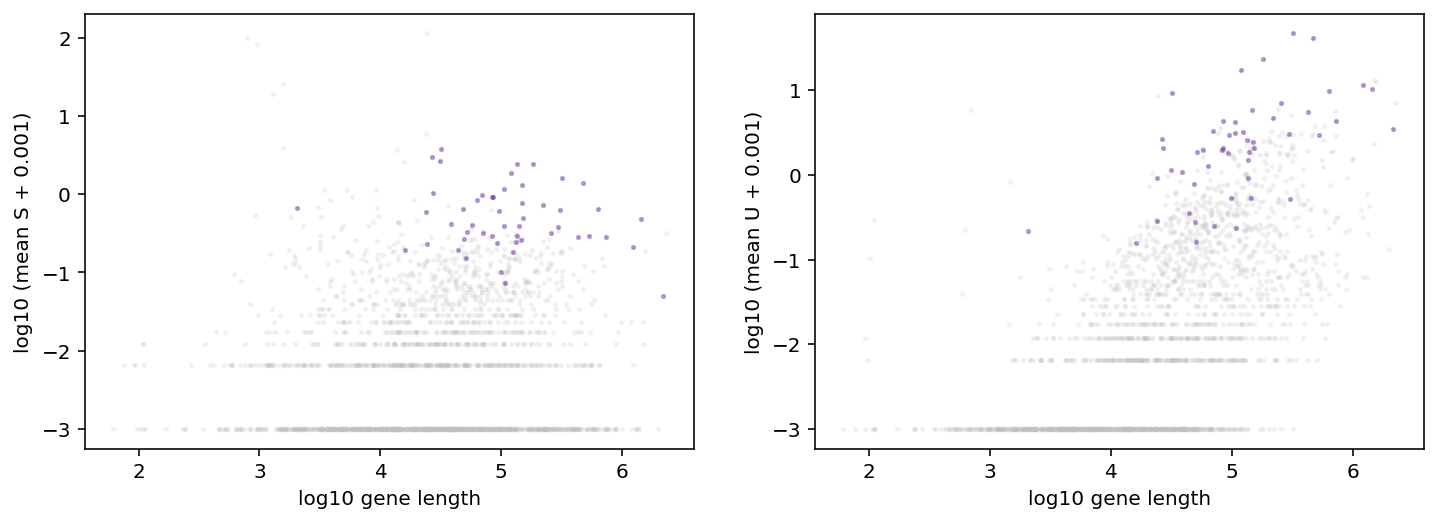

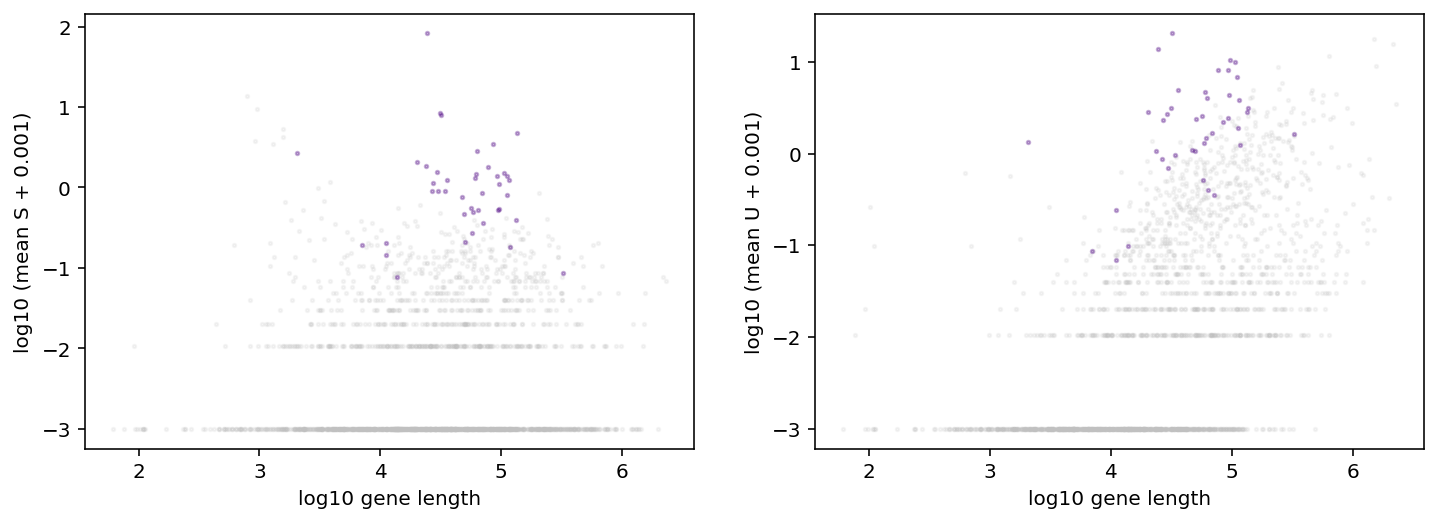

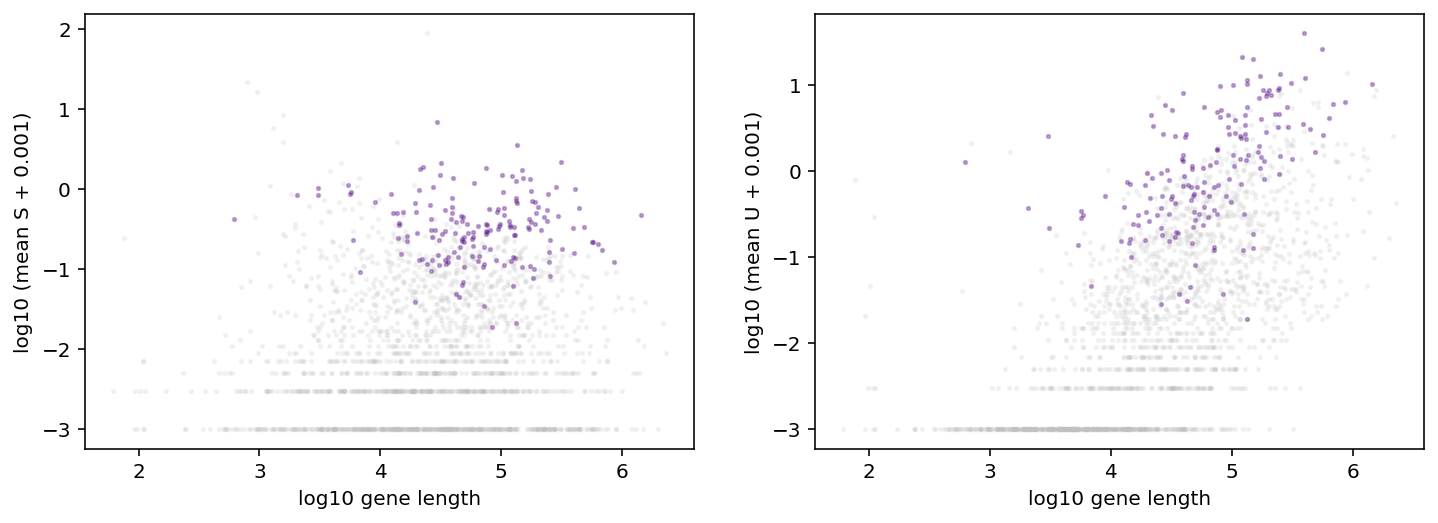

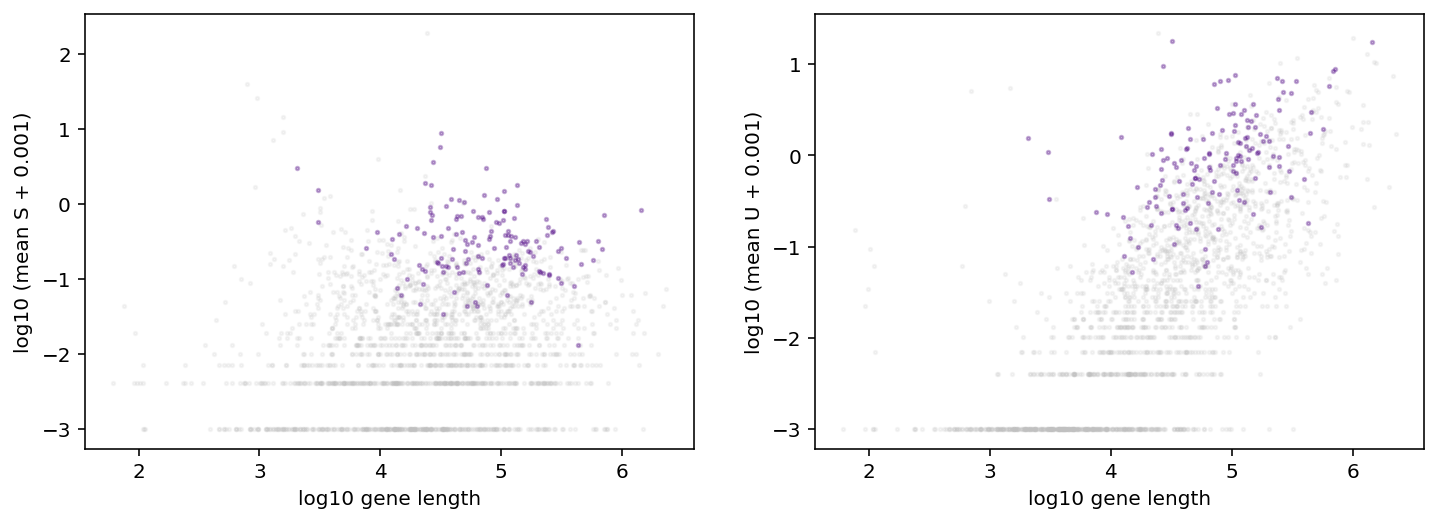

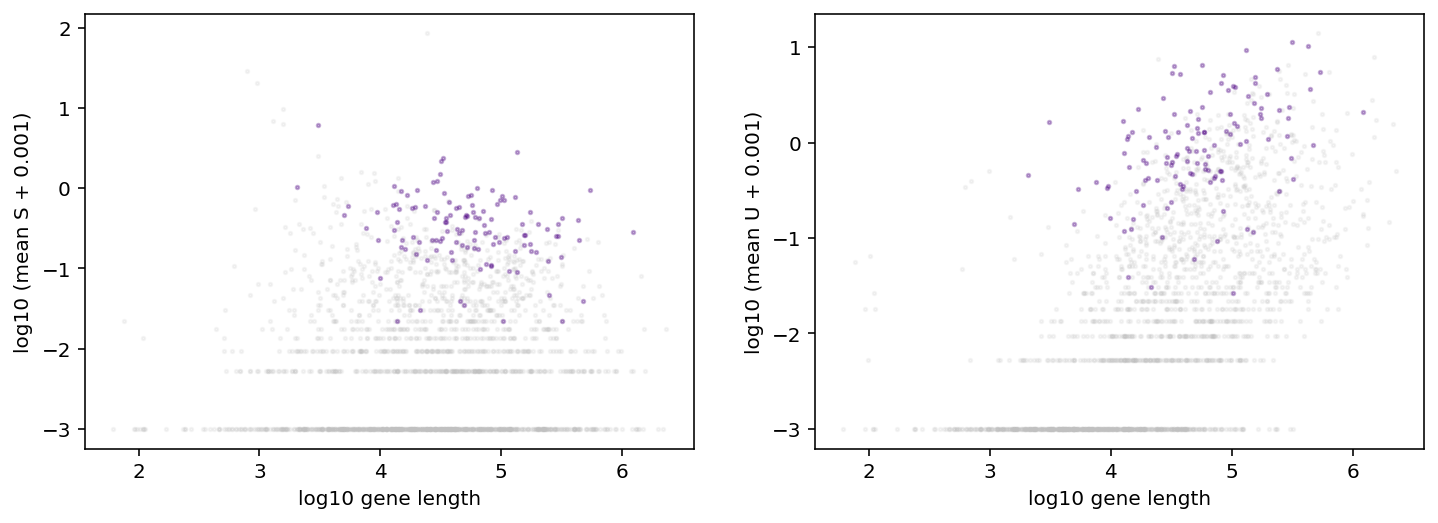

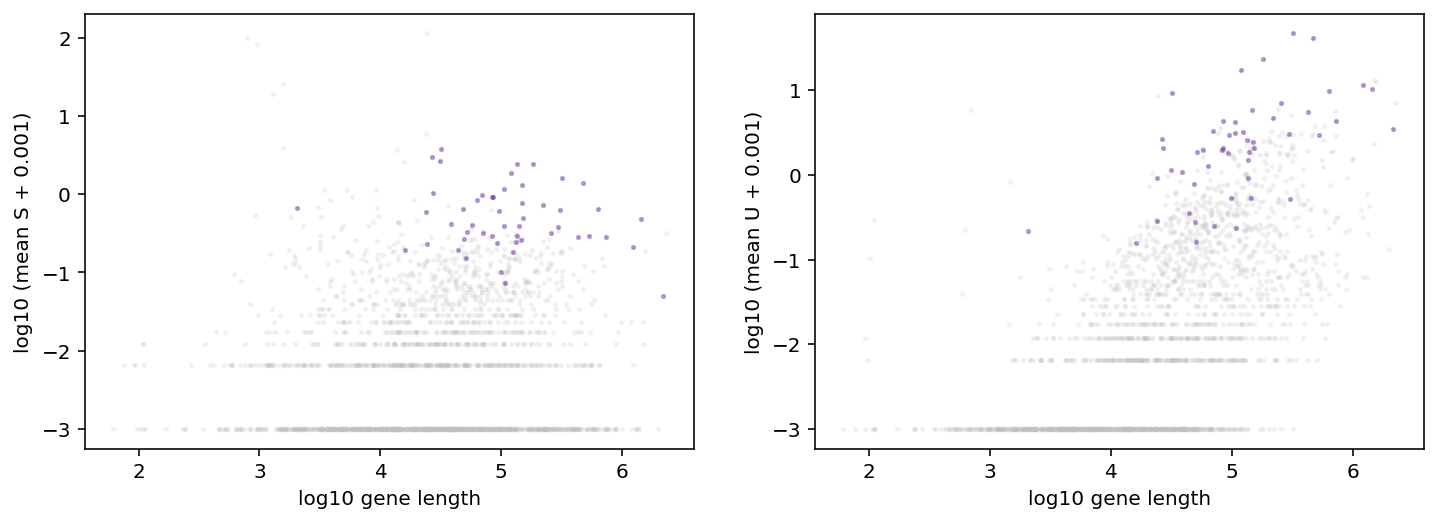

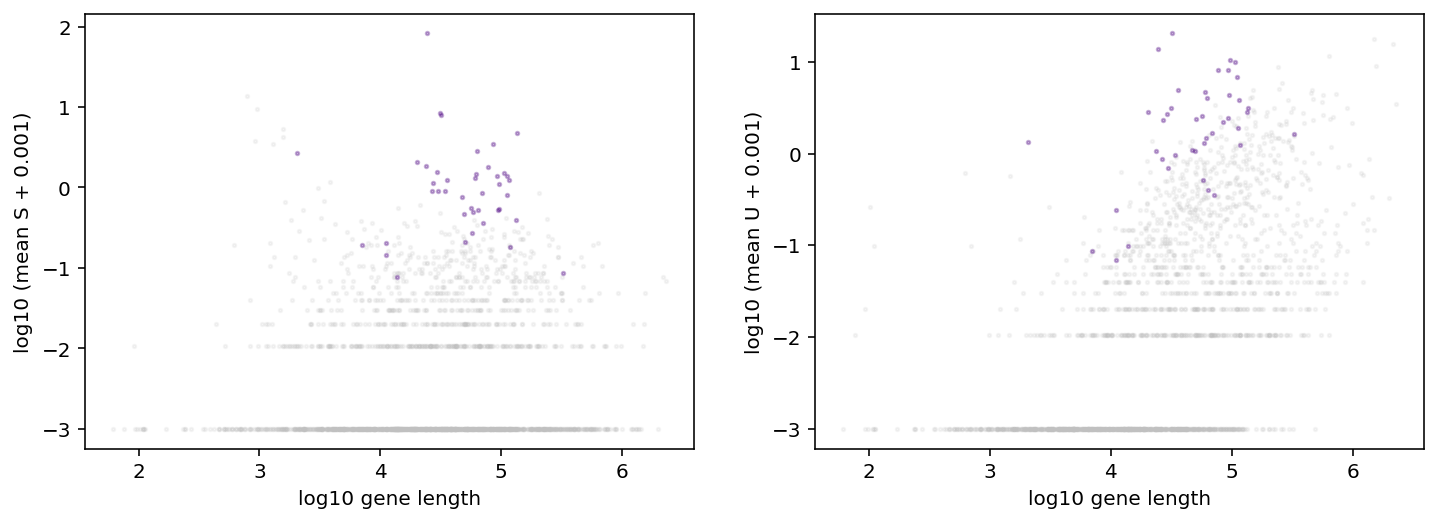

In [134]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='liver_MM',batch_id=1,\
                                             datestring='230419', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf) 

Check k-means inits

INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3
INFO:root:2000 features observed, 1987 match genome annotations. 1975 were unique.
INFO:root:Gene list extracted from ./fits/gg_230419_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230419_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3/raw.sd.
(1360, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5
INFO:root:2000 features observed, 1987 match genome annotations. 1975 were unique.
INFO:root:Gene list extracted from ./fits/gg_230419_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230419_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5/raw.sd.
(1360, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k7
INFO:

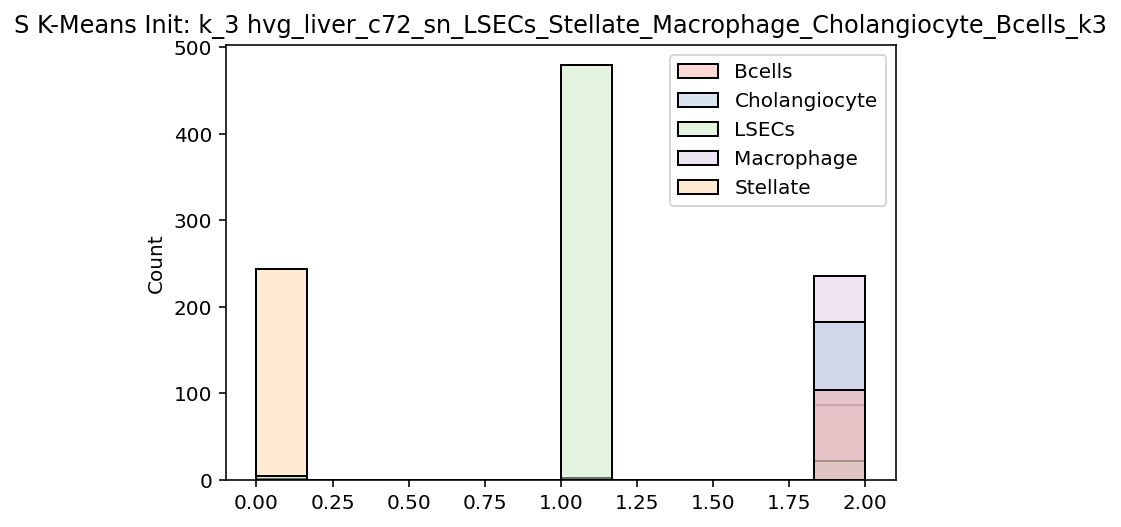

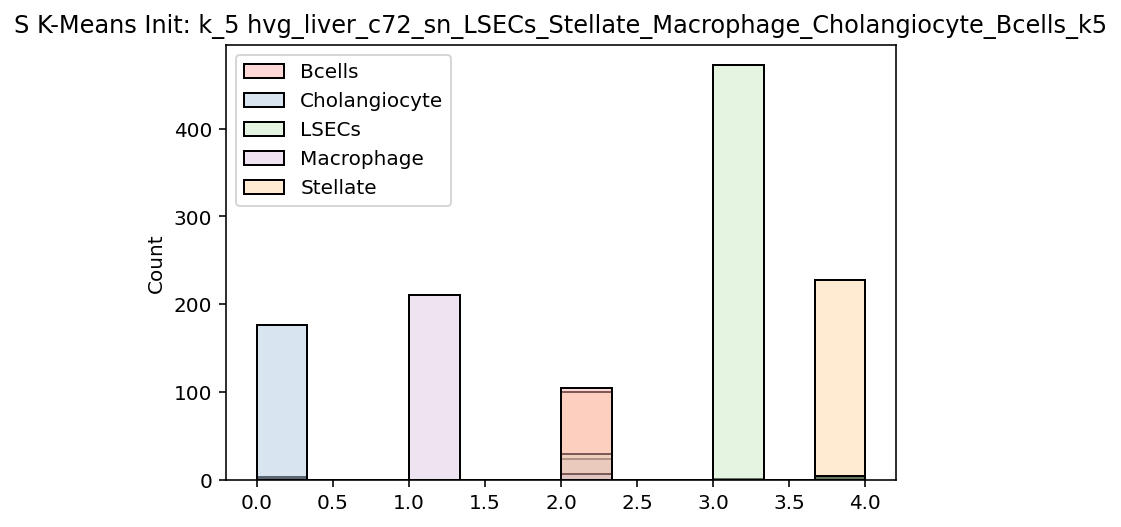

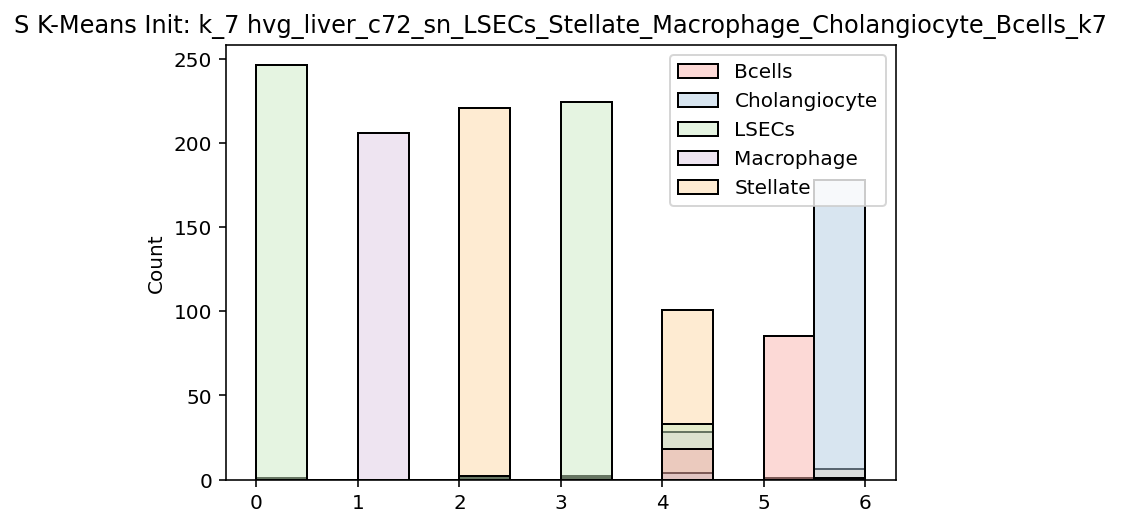

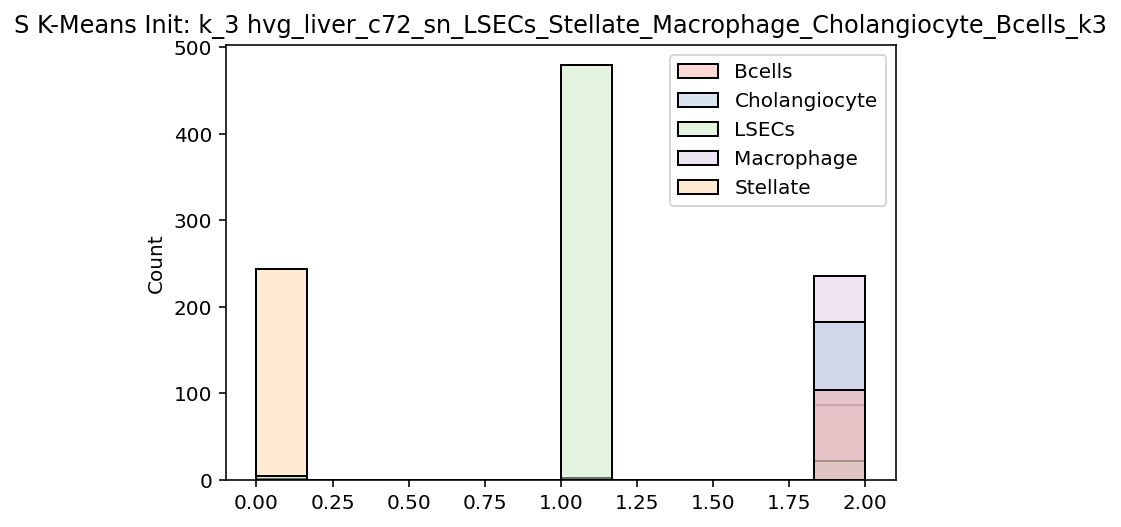

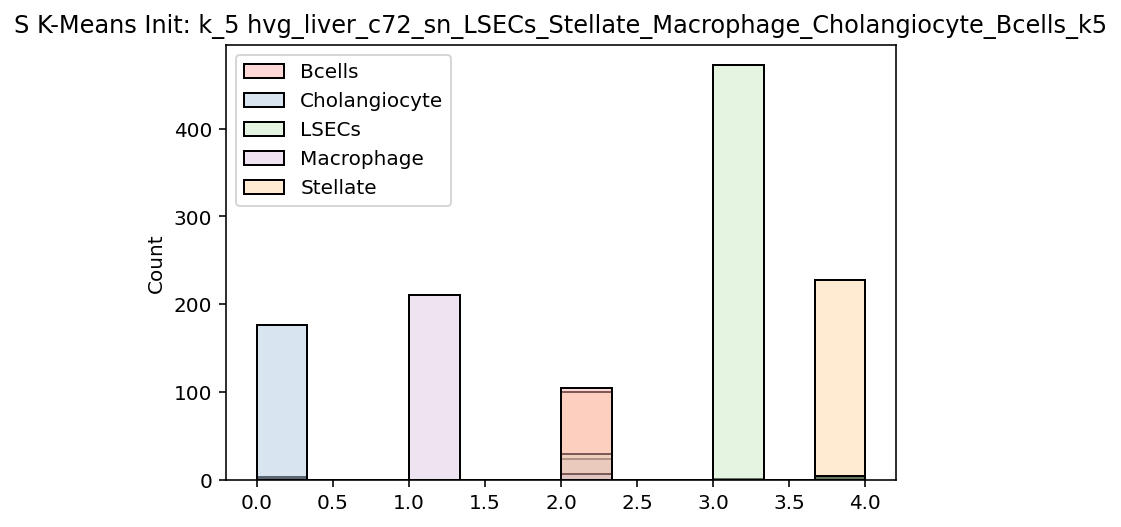

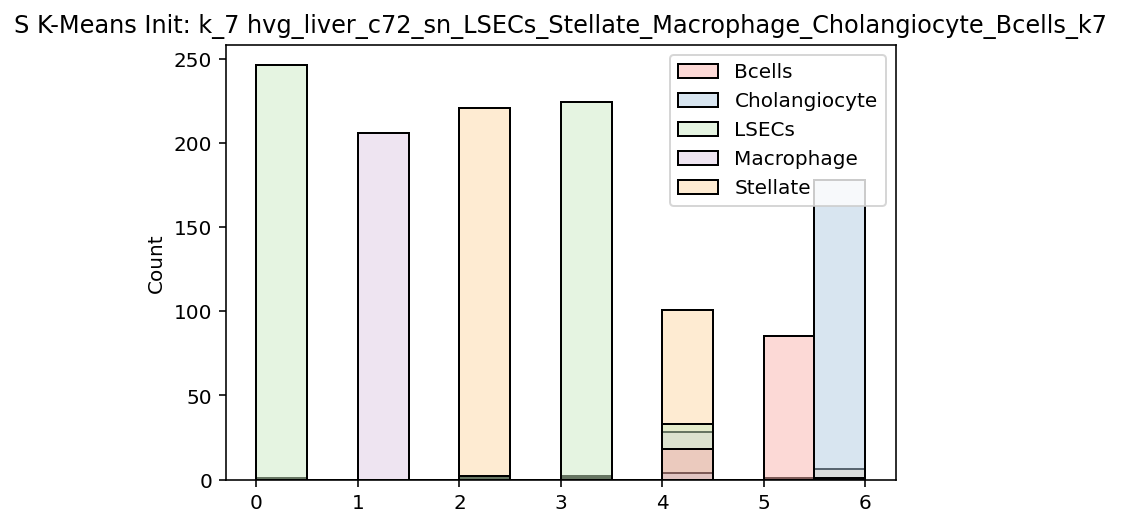

In [135]:
#For easier demonstration
#Check initializations of clusters
for i in range(len(ks)):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1')
    plt.title('S K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])




INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3
INFO:root:2000 features observed, 1987 match genome annotations. 1975 were unique.
INFO:root:Gene list extracted from ./fits/gg_230419_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230419_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k3/raw.sd.
(1360, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5
INFO:root:2000 features observed, 1987 match genome annotations. 1975 were unique.
INFO:root:Gene list extracted from ./fits/gg_230419_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230419_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k5/raw.sd.
(1360, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_Macrophage_Cholangiocyte_Bcells_k7
INFO:

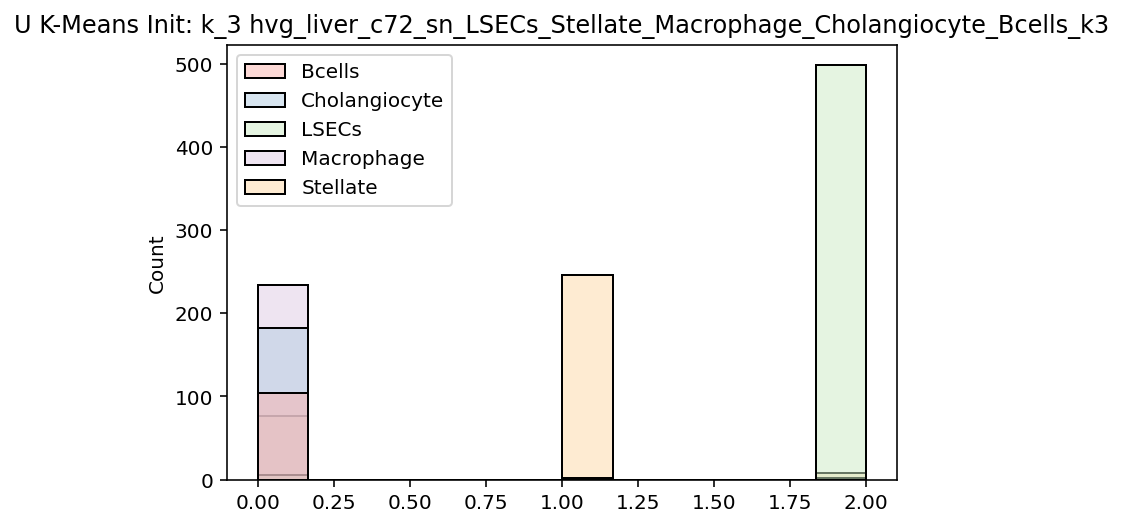

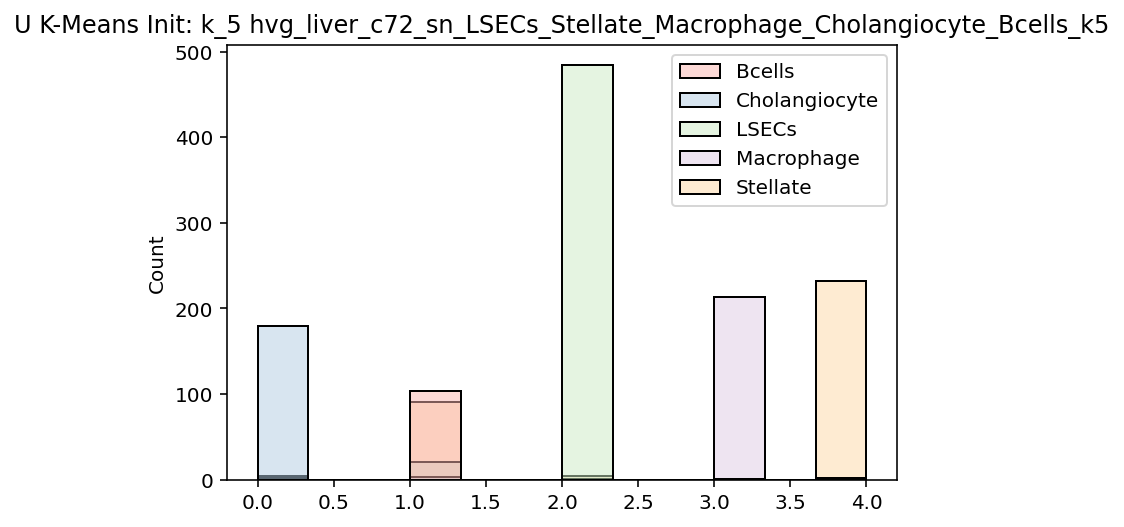

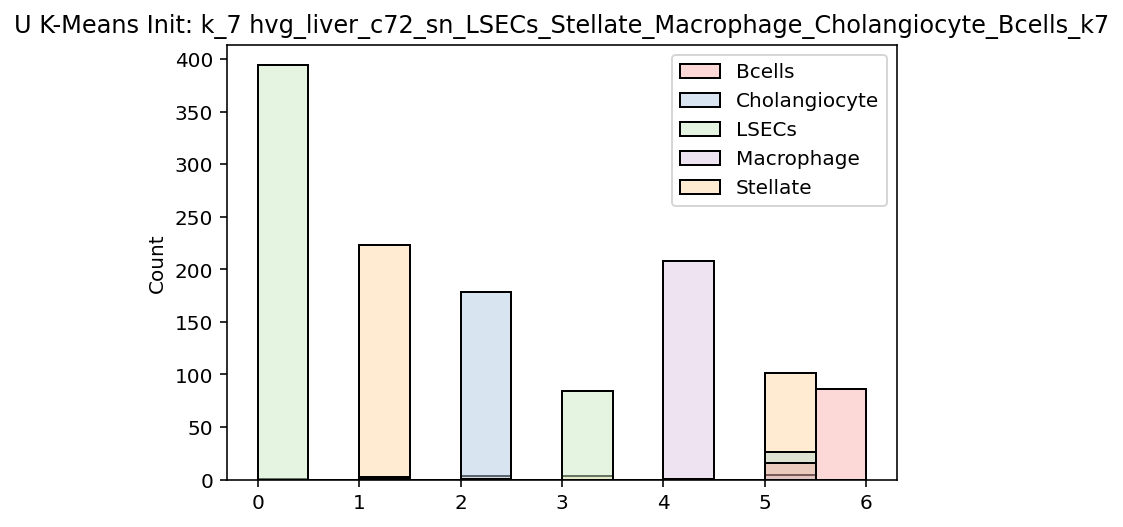

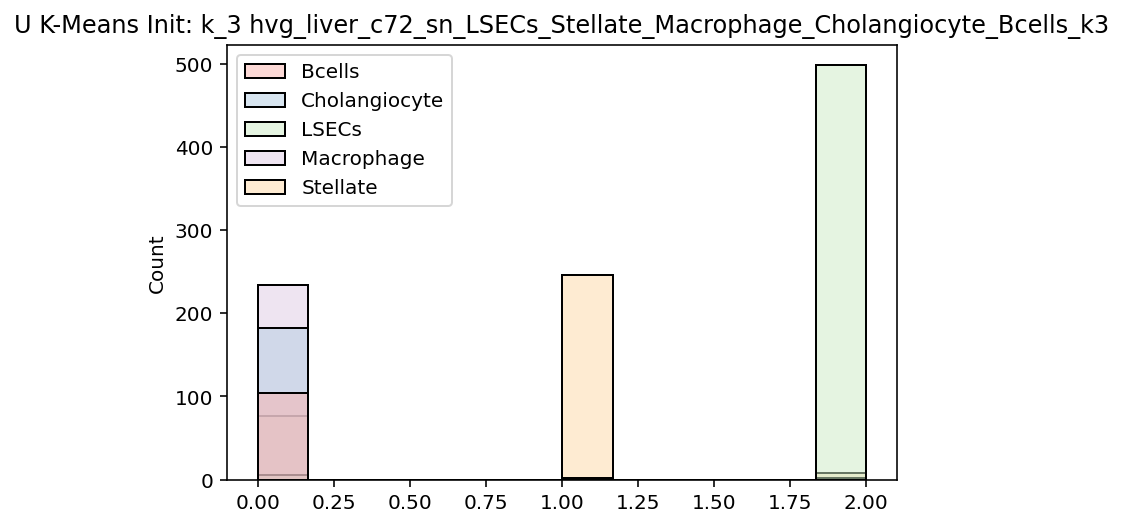

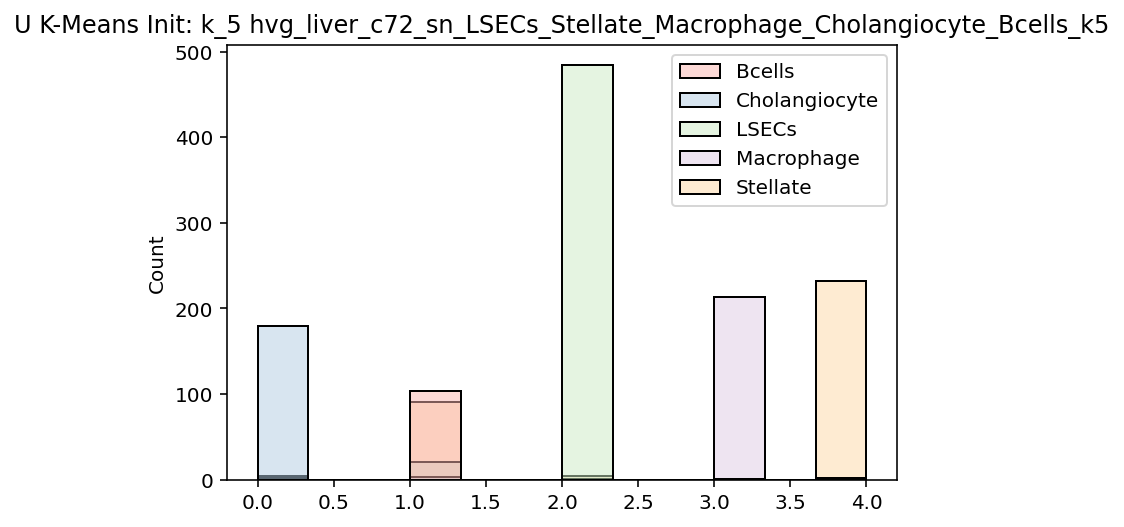

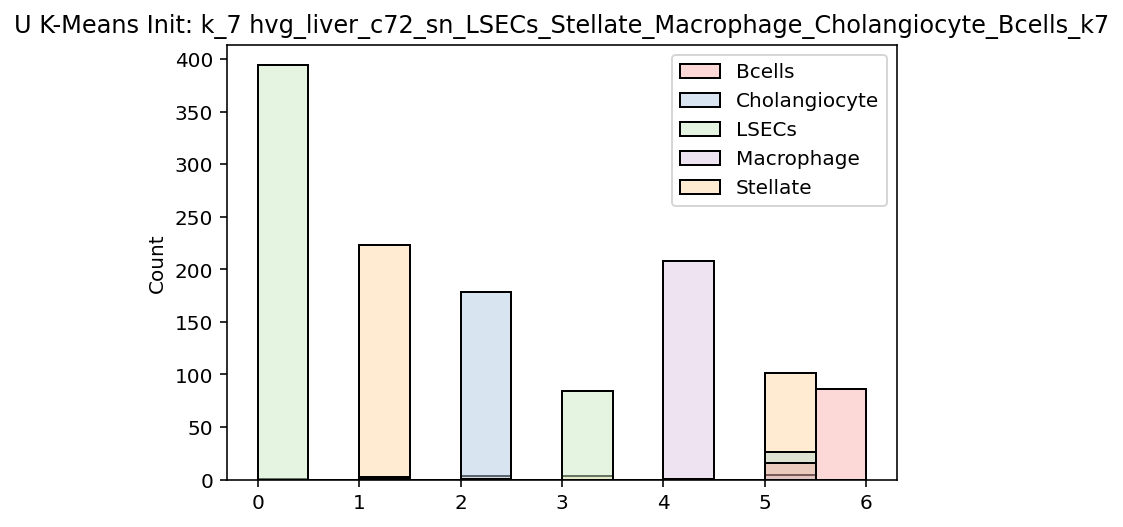

In [136]:
for i in range(len(ks)):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1')
    plt.title('U K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])
